<a href="https://colab.research.google.com/github/aiboyko/nbv-net/blob/master/NBW_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBV-Net 
This is a colab version of the modified code for Next Best View network proposed by Mendoza et al. 

[Original Paper](https://arxiv.org/pdf/1905.05833.pdf)

[Full Code](https://github.com/aiboyko/nbv-net)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import numpy as np
import csv

import classification_nbv as cnbv
import nbvnet

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
from torch import optim

from torch.autograd import Variable

In [0]:
display_dataset = True
display_fwd_pretraining = True
reading_weights_file = '/content/gdrive/My Drive/NBV/weights/paper_param.pth'
saving_weights_file = '/content/gdrive/My Drive/NBV/weights.pth'
epochs = 400
batch_size = 1000
learning_rate = 0.001
dropout_prob= 0.3

Check for GPU:

In [3]:
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
device = torch.device("cuda:0")
print(device)

Torch 1.5.0+cu101 CUDA 10.1
cuda:0


In [0]:
params = {'epochs': epochs, 
          'batch_size': batch_size, 
          'learning_rate': learning_rate, 
          'dropout_prob': dropout_prob}

with open("/content/gdrive/My Drive/NBV/log/parameters.csv", 'w') as csvfile:
    fieldnames = params.keys()  #['first_name', 'last_name', 'Grade']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
 
    writer.writeheader()
    writer.writerow(params)

## Dataset Preprocessing

Read the pose that corresponds to a class:

In [0]:
nbv_positions = np.genfromtxt('/content/gdrive/My Drive/NBV/nbv-dataset/points_in_sphere.txt')

In [0]:
def getPosition(nbv_class, nbv_positions):
    return nbv_positions[nbv_class]

In [0]:
gridfile_training = '/content/gdrive/My Drive/NBV/nbv-dataset/training/dataset_vol_classification_training.npy'
nbv_class_file_training = '/content/gdrive/My Drive/NBV/nbv-dataset/training/dataset_lbl_classification_training.npy'

In [0]:
training_dataset = cnbv.NBVClassificationDatasetFull(grid_file=gridfile_training, 
                                    nbv_class_file=nbv_class_file_training,
                                    transform=transforms.Compose([
                                    # Reshapes the plain grid
                                    cnbv.To3DGrid(),
                                    #converts to tensors
                                    cnbv.ToTensor()
                                    ])
                                    )

In [0]:
gridfile_validation = '/content/gdrive/My Drive/NBV/nbv-dataset/validation/dataset_vol_classification_validation.npy'
nbv_class_file_validation = '/content/gdrive/My Drive/NBV/nbv-dataset/validation/dataset_lbl_classification_validation.npy'

In [0]:
validation_dataset = cnbv.NBVClassificationDatasetFull(grid_file=gridfile_validation, 
                                    nbv_class_file=nbv_class_file_validation,
                                    transform=transforms.Compose([
                                    cnbv.To3DGrid(),
                                    cnbv.ToTensor()
                                    ])
                                    )

In [11]:
print('Training dataset lenght: ' + str(len(training_dataset)))
print('Validation dataset lenght: ' + str(len(validation_dataset)))

Training dataset lenght: 10764
Validation dataset lenght: 2691


0 torch.Size([1, 32, 32, 32]) torch.Size([])


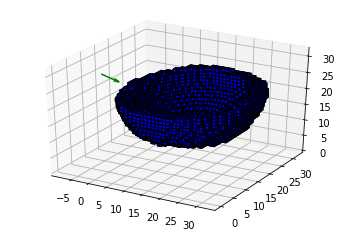

1 torch.Size([1, 32, 32, 32]) torch.Size([])


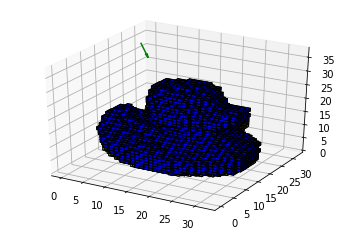

In [0]:
for i in range(len(training_dataset)):
    sample = training_dataset[i]

    print(i, sample['grid'].size(), sample['nbv_class'].size())
    
    if display_dataset:
        nbv = getPosition(sample['nbv_class'].numpy(), nbv_positions)
        nbv = np.squeeze(nbv)
        cnbv.showGrid(sample['grid'].numpy(), nbv)
    
    if i == 1:
        break

Load training data in batches:

In [0]:
train_loader = DataLoader(training_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

validation_loader = DataLoader(validation_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## NBV-Net

In [13]:
#net = nbvnet.NBV_Net_3FC(dropout_prob)
net = nbvnet.NBV_Net(dropout_prob)
#net4 = nbvnet.NBV_Net_4FC(dropout_prob)
net.to(device)
print(net)

NBV_Net(
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(10, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(12, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_drop): Dropout(p=0.3, inplace=False)
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=300, bias=True)
  (fc1_drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc2_drop): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)


Weights initialization

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.1)
        #m.weight.data.xavier_normal_()
        m.bias.data.fill_(0)
        
net.apply(weights_init)

NBV_Net(
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(10, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(12, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_drop): Dropout(p=0.3, inplace=False)
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=300, bias=True)
  (fc1_drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc2_drop): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

Test the model on a batch of test grids:

In [0]:
def net_sample_output():
    net.eval()
    for i, sample in enumerate(train_loader):
        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']

        # convert images to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)

        # forward pass to get net output
        output = net(grids)
        grids = grids.cpu()
        output = output.cpu()
        
        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(output.data, 1)

        # break after first image is tested
        if i == 0:
            return grids, predicted, nbvs

call the function that test the model on a batch    
returns: test images, test predicted keypoints, test ground truth keypoints

In [16]:
test_grids, test_outputs, gt_nbvs = net_sample_output()

print(test_grids.data.size())
print(test_outputs.data.size())
print(gt_nbvs.size())

torch.Size([1000, 1, 32, 32, 32])
torch.Size([1000])
torch.Size([1000])


In [0]:
def visualize_output(test_grids, test_outputs, gt_nbvs=None, batch_size=batch_size):

    for i in range(batch_size):

        # un-transform the image data
        grid = test_grids[i].data   # get the image from it's wrapper
        grid = grid.numpy()   # convert to numpy array from a Tensor

        print(test_outputs[i].data.numpy())
        # un-transform the predicted nbv
        predicted = getPosition( test_outputs[i].data.numpy(), nbv_positions)
        #print(predicted)
        
        print(gt_nbvs[i].numpy())
        gt = getPosition(gt_nbvs[i].numpy(), nbv_positions)
        #print(gt)
        
        cnbv.showGrid(grid, gt, predicted)
        #plt.show()
        
        if i==2:
            break

7
11


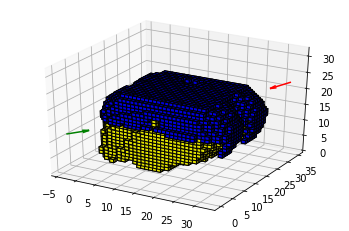

6
6


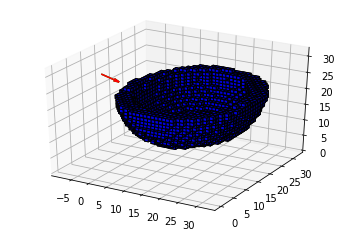

9
5


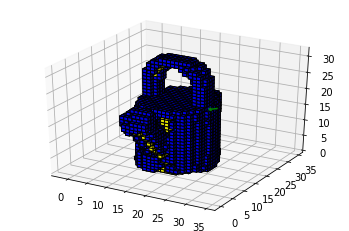

In [0]:
visualize_output(test_grids, test_outputs, np.squeeze(gt_nbvs))

## Training

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [0]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for sample in testloader:
        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']
        
        # convert images to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)
        
        # wrap them in a torch Variable
        nbvs = Variable(nbvs) 
        nbvs = nbvs.to(device)

        output = model.forward(grids)
        test_loss += criterion(output, nbvs).item()

        # for log.  ps = torch.exp(output)
        equality = (nbvs.data == output.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

Training loop:

In [19]:
running_loss = 0
save_after = 100

history_epoch = []
history_train_loss = []
history_validation_loss = []
history_train_accuracy = []
history_validation_accuracy = []

import time
tic = time.process_time()

for e in range(epochs):
    net.train()
    
    for i, sample in enumerate(train_loader):        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']

        # convert grids to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)
        
        # wrap them in a torch Variable
        nbvs = Variable(nbvs) 
        nbvs = nbvs.to(device)
        
        optimizer.zero_grad()

        # forward pass to get net output
        output = net(grids)
        
        #ot = output.cpu()
        #print(ot)    
        
        loss = criterion(output, nbvs)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
     
    net.eval()
            
    with torch.no_grad():
        train_loss, train_accuracy = validation(net, train_loader, criterion)
        val_loss, val_accuracy = validation(net, validation_loader, criterion)
        
        train_loss, train_accuracy = train_loss, train_accuracy.cpu().numpy()
        val_loss, val_accuracy = val_loss, val_accuracy.cpu().numpy()
        
        train_accuracy = train_accuracy / len(train_loader)
        val_accuracy = val_accuracy / len(validation_loader)
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Val. Loss: {:.3f}.. ".format(val_loss),
              "Train Accuracy: {:.3f}".format(train_accuracy),
              "Val. Accuracy: {:.3f}".format(val_accuracy))
    
    history_epoch.append(e)
    history_train_loss.append(train_loss)
    history_validation_loss.append(val_loss)
    history_train_accuracy.append(train_accuracy)
    history_validation_accuracy.append(val_accuracy)
    
    running_loss = 0
    
    if(e % save_after == 0):
        np.save('/content/gdrive/My Drive/NBV/log/train_loss'+str(e), history_train_loss)
        np.save('/content/gdrive/My Drive/NBV/log/validation_loss'+str(e), history_validation_loss)
        np.save('/content/gdrive/My Drive/NBV/log/train_accuracy'+str(e), history_train_accuracy)
        np.save('/content/gdrive/My Drive/NBV/log/validation_accuracy'+str(e), history_validation_accuracy)
        torch.save(net.state_dict(), '/content/gdrive/My Drive/NBV/log/weights'+str(e)+'.pth')
    
    # Make sure training is back on
    net.train()

toc = time.process_time()
print(toc - tic)

Epoch: 1/400..  Training Loss: 28.719..  Val. Loss: 7.837..  Train Accuracy: 0.116 Val. Accuracy: 0.114
Epoch: 2/400..  Training Loss: 28.685..  Val. Loss: 7.828..  Train Accuracy: 0.116 Val. Accuracy: 0.115
Epoch: 3/400..  Training Loss: 28.625..  Val. Loss: 7.805..  Train Accuracy: 0.138 Val. Accuracy: 0.140
Epoch: 4/400..  Training Loss: 28.558..  Val. Loss: 7.794..  Train Accuracy: 0.137 Val. Accuracy: 0.135


KeyboardInterrupt: ignored

In [0]:
from google.colab import files

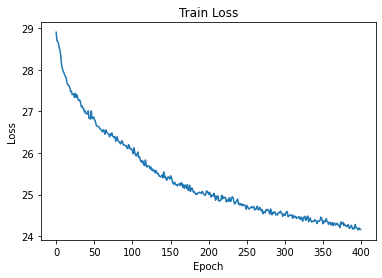

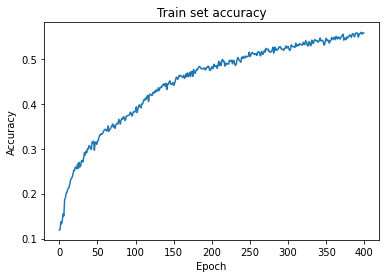

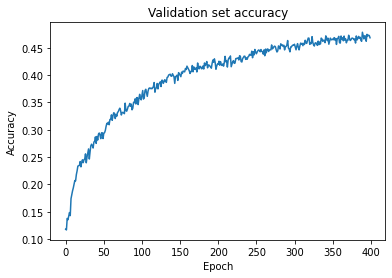

In [0]:
import matplotlib.pyplot as plt

plt.plot(history_epoch, history_train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.savefig('train_loss.png', dpi = 200)
files.download("train_loss.png")
plt.show()

plt.plot(history_epoch, history_train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train set accuracy')
plt.savefig('train_accuracy_xavier.png', dpi = 200)
files.download("train_accuracy_xavier.png")
plt.show()

plt.plot(history_epoch, history_validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation set accuracy')
plt.savefig('validation_accuracy_xavier.png', dpi = 200)
files.download("validation_accuracy_xavier.png")
plt.show()



In [0]:
np.save('/content/gdrive/My Drive/NBV/log/train_loss_3layers', history_train_loss)
np.save('/content/gdrive/My Drive/NBV/log/validation_3layers', history_validation_loss)
np.save('/content/gdrive/My Drive/NBV/log/train_accuracy_3layers', history_train_accuracy)
np.save('/content/gdrive/My Drive/NBV/log/validation_accuracy_3layers', history_validation_accuracy)